In [ ]:
!pip install -q mlxtend

In [1]:
# importamos las librerias necesarias
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import numpy as np
np.random.seed(42)

In [35]:
DATA_PATH = "../data"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "train_set_limpio.csv")
    return pd.read_csv(csv_path)

def load_data_test(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "test_set_limpio.csv")
    return pd.read_csv(csv_path)

In [36]:
train_set = load_data_prep()
test_set = load_data_test()
test_set.shape, train_set.shape

((13, 291), (52, 292))

In [37]:
test_set.loc[test_set.cod.str.contains('sub-500'),'label'] = '1'
test_set.loc[test_set.cod.str.contains('sub-10'),'label'] = '0'

In [38]:
test_set.shape, train_set.shape

((13, 292), (52, 292))

In [4]:
train_set.head()

,cod,afsl_ad,afsl_area_of_end_region_1,afsl_area_of_end_region_2,afsl_branch_volume,afsl_curl,afsl_diameter,afsl_dti_fa,afsl_elongation,afsl_irregularity,...,ufsr_radius_of_end_region_2,ufsr_rd,ufsr_rdi,ufsr_span,ufsr_total_area_of_end_regions,ufsr_total_radius_of_end_regions,ufsr_total_surface_area,ufsr_trunk_volume,ufsr_volume,label
0,sub-50027,1.19677,1275.02,1948.760,105.762,2.43909,16.8394,0.459764,4.65699,6.90148,...,9.25850,0.627177,0.426580,30.8102,2687.13,18.4754,28716.3,17617.20,17790.5,1
1,sub-10274,1.07700,1198.63,1587.400,9722.240,2.37217,16.7635,0.421061,4.59672,7.99467,...,7.23760,0.592179,0.170609,33.3155,2670.48,15.8142,23441.9,14133.90,14682.3,0
2,sub-10206,1.22377,1466.95,1891.960,342.746,2.52608,18.5337,0.451700,4.03394,8.68243,...,9.50629,0.600089,0.148309,25.5444,3499.93,19.6383,31524.8,13911.60,18435.8,0
3,sub-50007,1.13453,2094.67,523.912,3571.420,2.77770,16.1605,0.432708,4.82994,7.73849,...,7.80405,0.610717,0.147398,28.4403,2174.97,20.4172,29801.3,6769.73,15710.5,1
4,sub-50035,1.16772,1585.45,1425.820,7349.460,2.85153,16.4502,0.442665,4.49464,8.32095,...,9.05802,0.589037,0.334109,23.2758,4041.47,22.4243,32685.3,11486.90,19568.9,1


In [14]:
X = train_set.drop(['cod', 'label'], axis=1).values
y = train_set['label']


### Efecto del umbral de clasificación en el error

Vamos a construir un clasificador **sin balancear** con todas las features, pero en vez de obtener las predicciones binarias, vamos a obtener las probabilidades.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar

# Definamos la matriz X
X = train_set.drop(['cod', 'label'], axis=1).values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = train_set['label'] # Nuestra etiqueta sigue siende la misma de antes

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. osPor defecto, esto normaliza l datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X = scaler.transform(X) # aplico la transformacion

regLog = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
probas = regLog.predict_proba(X)  # este es el metodo para obtener las predicciones de probabilidades en base a la matriz features
print(probas)


La primera columna es $P(y=0|x,\beta)$. 

La segunda es $P(y=1|x,\beta)$. 

Entonces, el clasificador por defecto predice etiqueta $1$ si $P(y=1|x,\beta) > 0.5$, o sea, cuando la segunda columna es mayor que 0.5 y la etiqueta $0$ en caso contrario.

Pero podemos introducir un umbral arbitrario $T$ para determinar la etiqueta $1$ si $P(y=1|x,\beta) > T$. 

Veamos como queda la matriz de confusión para distintas elecciones de T.

Ademas, vamos a calcular dos medidas de performance útiles para más adelante:

*   Tasa de verdaderos positivos (sensibilidad)$ = \frac{TP}{TP+FN}$
*   Tasa de falsos positivos $ = \frac{FP}{FP+TN}$

donde TP = verdaderos positivos, FN = falsos negativos, FP = falsos positivos y TN = verdaderos negativos.

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt # Para gráficos

def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos

T = 0.5 # definimos el umbral
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))  
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4)))  


Matriz de confusion del modelo es:
[[34  0]
 [ 0 18]]
Tasa de verdaderos positivos: 1.0
Tasa de falsos positivos: 0.0


El dataset está desbalanceado, tendemos a detectar pocos verdaderos positivos (días de lluvia) a cambio de que haya pocos falsos positivos. 

**En otras palabras: el clasificador está sesgado para predecir que no llueve.**

Pero si bajamos el umbral T, deberíamos encontrar que se hace más fácil predecir que llueve, y entonces que la matriz se balancea:

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]


Text(0, 0.5, 'Tasa de verdaderos positivos')

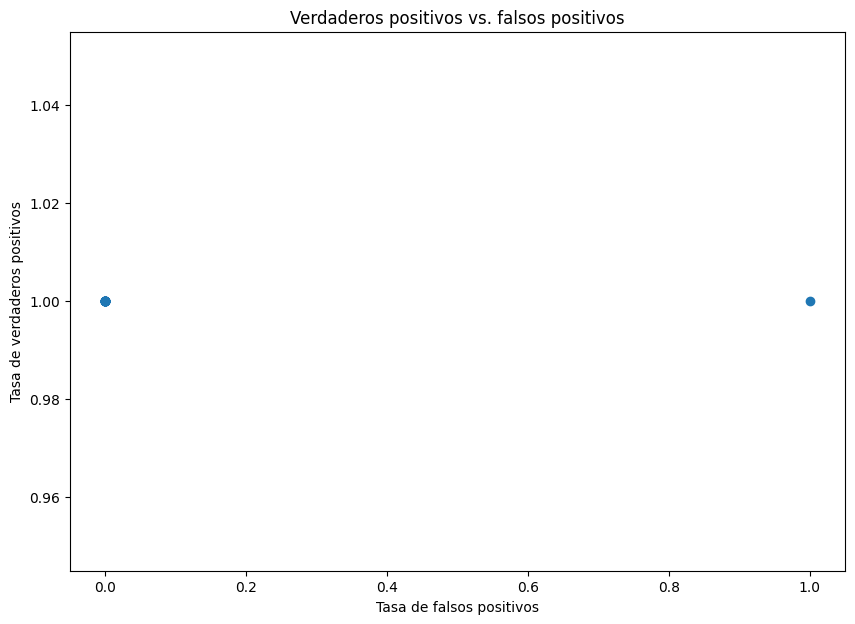

In [27]:
Ts = np.arange(0,1,0.05) # T va desde 0 a 1 en pasos de 0.05
print(Ts)
TPRs = []  # lista donde van a ir a parar mis tasas de verdaderos positivos
FPRs = []  # lista donde van a ir a parar mis tasas de falsos positivos
for T in Ts: # recorre los umbrales en la lista Ts
  ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
  ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
  cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
  metricas = TPR_FPR(cm) # calculamos las metricas con la función definida más arriba
  TPRs.append(metricas[0]) # guardamos los resultados en las listas respectivas
  FPRs.append(metricas[1])

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.scatter(FPRs,TPRs)
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

Text(0, 0.5, 'Tasa de verdaderos positivos')

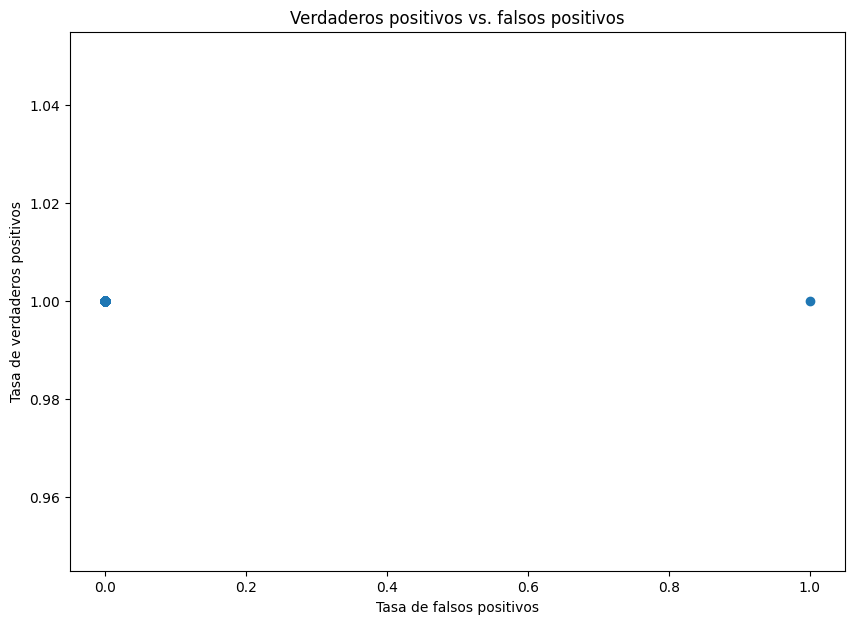

In [28]:
Ts = np.arange(0,1,0.001) # T va desde 0 a 1 en pasos de 0.001

TPRs = []  # lista donde van a ir a parar mis tasas de verdaderos positivos
FPRs = []  # lista donde van a ir a parar mis tasas de falsos positivos
for T in Ts: # recorre los umbrales en la lista Ts
  ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
  ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
  cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
  metricas = TPR_FPR(cm) # calculamos las metricas con la función definida más arriba
  TPRs.append(metricas[0]) # guardamos los resultados en las listas respectivas
  FPRs.append(metricas[1])

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.scatter(FPRs,TPRs)
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

AUC: 1.0


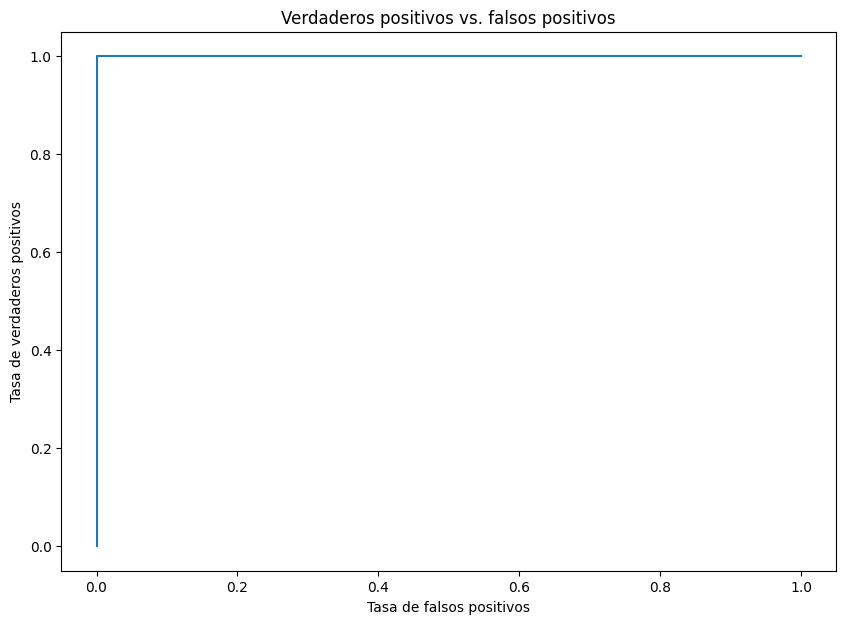

In [29]:
from sklearn.metrics import roc_curve # función curva ROC de scikit-learn
from sklearn.metrics import roc_auc_score # función AUC de scikit-learn

fpr, tpr, thresholds = roc_curve(y, probas[:,1]) # Función ROC: recibe las etiquetas verdaderas y las probas de que sean 1
                                                # Devuelve las tastas de falsos positivos y verdaderos positivos, además de los 
                                                # umbrales a los que están calculados
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr) # Gráfico de TPR vs FPR
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

auc = roc_auc_score(y, probas[:,1]) # Cálculo del área debajo de la curva, recibe también las etiquetas verdaderas 
                                    # y la proba de que valgan 1.

print('AUC: {}'.format(round(auc,4))) # mostramos el AUC con 4 cifras significativas 

En un problema típico tenemos varias variables independientes que podemos usar para entrenar nuestro modelo, o sea, incorporar como features. El problema es que no todos los features son igualmente informativos. Es importante partir de una buena base para esperar que un clasificador tenga un buen desempeño.

Partamos entonces de un clasificador que incorpora varios features para el problema de predecir y estimemos el AUC haciendo una validación cruzada estratificada con 5 folds.

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definamos la matriz X
X = train_set.drop(['cod', 'label'], axis=1).values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = train_set['label'] # Nuestra etiqueta sigue siende la misma de antes

X = np.concatenate((X, X**2,X**3), axis=1) # agrego features elevados a potencias 

skf = StratifiedKFold(n_splits=10, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_test) 
    X_test = scaler.transform(X_test)

    regLog = LogisticRegression( max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
    auc_values.append(auc_test)
print(np.mean(auc_values))

0.6583333333333334


Ahora supongamos que en cada fold decidimos quedarnos con una cantidad reducida de features, por ejemplo, con los K mejores features de acuerdo a un criterio *univariado*. La idea es que en cada fold tenemos en los datos de entrenamiento las etiquetas de la clase de cada ejemplo. Entonces para cada variable por separado podemos obtener una medida de qué tan distinta es dicha variable entre ambas clases. Entonces, vamos a retener las K variables que más diferentes sean entre clases para entrenar cada clasificador. 

Para esto, vamos a usar la función usando la estadística F de ANOVA entre grupos para rankear las mejores features **en cada fold por separado.**

(si hacemos esto antes de dividir en folds, vamos a estar en problemas, porque habremos usado datos de todo el conjunto para determinar el score F y por lo tanto rankear features, pero entonces habremos pasado datos del conjunto de evaluacion al de entrenamiento cuando dividamos en folds)

El AUC promedio es:
0.5416666666666666


Text(0, 0.5, 'Folds')

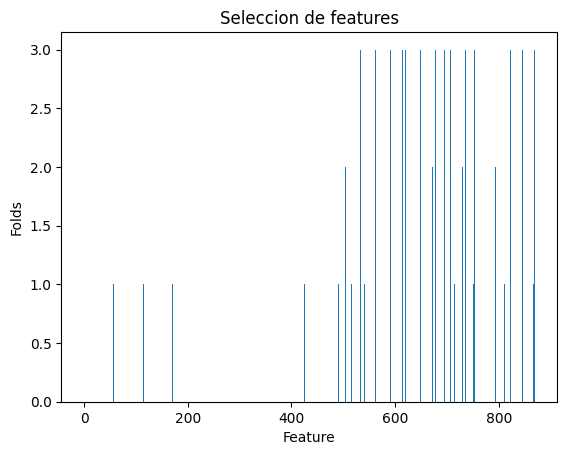

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest

# Definamos la matriz X
X = train_set.drop(['cod', 'label'], axis=1).values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = train_set['label'] # Nuestra etiqueta sigue siende la misma de antes

X = np.concatenate((X, X**2,X**3), axis=1) # agrego features elevados a potencias 

Kbest = 30 # los mejores K que voy a retener

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values_fs =  []  # aca es donde van a ir a parar los indices de los features seleccionados en cada fold
selected_features= np.array([]).reshape(0,X.shape[1]) # aca es donde van a ir a parar los AUCs de cada fold. El reshape es para poder concatenar luego.


for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_test) 
    X_test = scaler.transform(X_test)

    selector = SelectKBest(k=Kbest) # por defecto, usa el F score de ANOVA y los Kbest features
    selector.fit(X_train, y_train) # encuentro los F scores 
    X_train_fs = selector.transform(X_train) # me quedo con los features mejor rankeados en el set de entrenamiento
    X_test_fs = selector.transform(X_test) # me quedo con los features mejor rankeados en el set de evaluacion
    features = np.array(selector.get_support()).reshape((1,-1)) # esto me pone True si la variable correspondiente fue seleccionada y False sino

    selected_features =  np.concatenate((selected_features,features),axis=0)

    regLog = LogisticRegression(max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog.fit(X_train_fs, y_train) # Ajustamos el modelo con los datos de entrenamiento


    probas_test = regLog.predict_proba(X_test_fs)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
    auc_values_fs.append(auc_test)

print('El AUC promedio es:')
print(np.mean(auc_values_fs))


import matplotlib.pyplot as plt

plt.bar(np.arange(0,X.shape[1]),np.sum(selected_features,axis=0))
plt.title('Seleccion de features')
plt.xlabel('Feature')
plt.ylabel('Folds')

Retengo 30 features en 5 folders, es decir, 6 features por folder. Para cada folder, entreno un modelo con los 6 features y calculo el AUC sobre el mismo folder. Luego, calculo el AUC promedio y el desvío estándar de los 5 AUCs obtenidos.

Vemos que el AUC promedio obtenido con los K=10 mejores features no es mejor que el AUC obtenido con todos. Esto significa que en este dataset la clasificación no esta basada en un conjunto pequeño de features muy diferentes entre las dos clases, sino que todas parecen contribuir.

# Modelo nulo

Supongamos que queremos construir un modelo que sepamos es incapaz de clasificar los datos por encima del nivel azar. Una forma de hacer esto es randomizando (shuffleando) las etiquetas. Si permutamos las etiquetas al azar, entonces rompemos la relación entre features y targets, y podemos asumir que no hay nada útil que el clasificador pueda aprender, de forma tal que el AUC de este modelo nos da una buena idea de lo que podemos obtener al nivel chance.

Veamos cómo se ve el ROC plot para datos con y sin randomización de labels.

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definamos la matriz X
X = train_set.drop(['cod', 'label'], axis=1).values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = train_set['label'] # Nuestra etiqueta sigue siende la misma de antes

X_test = test_set.drop(['cod', 'label'], axis=1).values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos


scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_test) 
X = scaler.transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression( max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)
    targets = np.concatenate((targets,y_test),axis=0)


print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

Estos son los valores AUC para cada fold:
[0.8214285714285714, 0.6071428571428572, 0.24999999999999997, 0.5238095238095237, 0.7619047619047619]
Estos es el promedio de todos los AUC:
0.5928571428571429


In [ ]:
X

In [45]:
from sklearn.preprocessing import MinMaxScaler # para escalar los datos
X = train_set.drop(['cod', 'label'], axis=1).values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = train_set['label'] # Nuestra etiqueta sigue siende la misma de antes
print(scaler.fit(X))


MinMaxScaler()


In [49]:
print(scaler.transform(X))

[[0.48264543 0.49926992 0.65057086 ... 0.62041609 0.5748942  0.57609959]
 [0.11862501 0.46116205 0.50569138 ... 0.49246984 0.45325331 0.46846312]
 [0.56470731 0.595016   0.62779813 ... 0.68854461 0.44549033 0.59844623]
 ...
 [1.         0.19052287 0.25873593 ... 0.93491101 0.57232749 0.79130673]
 [0.37289526 0.45432269 0.74754742 ... 0.68809341 0.46594017 0.5420169 ]
 [0.52768829 0.49047503 0.6266194  ... 0.4876231  0.17922868 0.41691661]]


In [40]:
from numpy.random import shuffle # para shufflear el vector
from sklearn.preprocessing import MinMaxScaler # para escalar los datos

scaler = MinMaxScaler()
# Definamos la matriz X
X = train_set.drop(['cod', 'label'], axis=1).values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = train_set['label'] # Nuestra etiqueta sigue siende la misma de antes
scaler = MinMaxScaler() # escaleo por separado ambos sets

scaler.fit(X_test) 
X = scaler.transform(X)

y_shuffled = y.copy() # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffled) # shuffleo

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y_shuffled) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores_shuffled = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices_shuffled = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets_shuffled = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y_shuffled): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores_shuffled  = np.concatenate((scores_shuffled ,probas_test[:,1]),axis=0)
    indices_shuffled  = np.concatenate((indices_shuffled ,test_index),axis=0)
    targets_shuffled  = np.concatenate((targets_shuffled ,y_test),axis=0)


print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

C:\Users\User\AppData\Local\Temp\ipykernel_10544\2563730039.py:13: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  shuffle(y_shuffled) # shuffleo
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs 

Estos son los valores AUC para cada fold:
[0.39285714285714285, 0.6428571428571428, 0.7142857142857143, 0.38095238095238093, 0.45833333333333337]
Estos es el promedio de todos los AUC:
0.5178571428571429


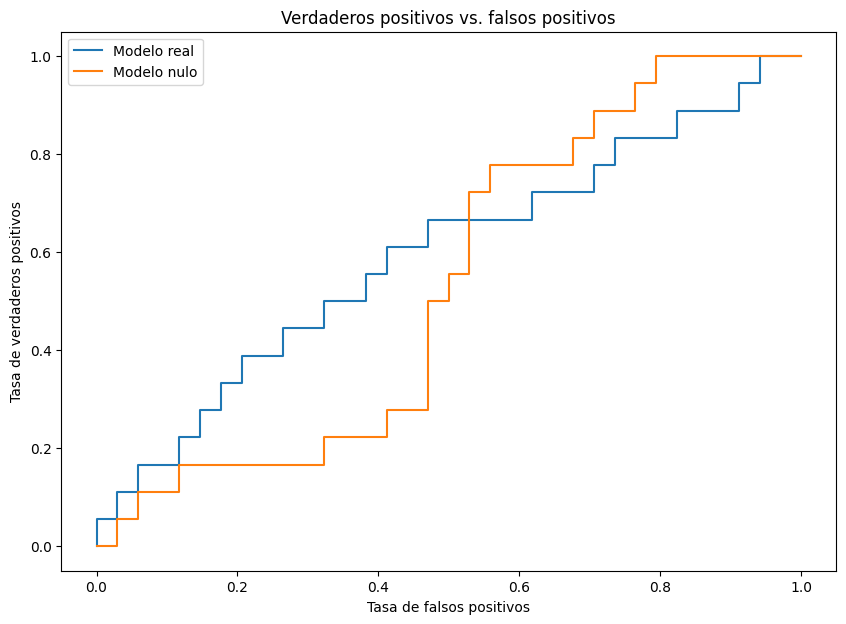

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# este codigo fue sacado del notebook de ROC AUC (clase 10) y sirve para visualizar la curva ROC

fpr, tpr, thresholds = roc_curve(targets, scores)
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(targets_shuffled, scores_shuffled)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr, label='Modelo real')
ax.plot(fpr_shuffled,tpr_shuffled, label='Modelo nulo')

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y
plt.legend()


In [42]:
from sklearn.model_selection import permutation_test_score

regLog = LogisticRegression( max_iter=30000) # creamos un objeto clasificador
skf = StratifiedKFold(n_splits=5, shuffle=True) # creamos un objeto de cross-validation

AUC, AUC_shuffled, pvalue = permutation_test_score(regLog, X, y, scoring="roc_auc", cv=skf, n_permutations=100) # aca aplico la funcion 
# Notar que la función de arriba recibe como argumentos el clasificador (regLog) y la forma de hacer validación cruzada (skf), 
# además de los datos y el número de permutaciones que hacemos para construir nuestro modelo al azar.

print('Sin shufflear:')
print(AUC)
print('Modelo nulo (shuffleando):')
print(AUC_shuffled)
print('p-valor:')
print(pvalue)

c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Sin shufflear:
0.5190476190476192
Modelo nulo (shuffleando):
[0.60714286 0.45       0.33095238 0.5        0.23809524 0.54166667
 0.66309524 0.56904762 0.51309524 0.45833333 0.50238095 0.45238095
 0.34285714 0.54761905 0.27738095 0.33690476 0.53690476 0.35
 0.45952381 0.53571429 0.54404762 0.56785714 0.54880952 0.57857143
 0.25714286 0.56666667 0.58928571 0.51309524 0.24642857 0.59761905
 0.47380952 0.43452381 0.50357143 0.54285714 0.40357143 0.46309524
 0.40357143 0.4547619  0.46309524 0.38452381 0.56190476 0.41428571
 0.47738095 0.36309524 0.6        0.55714286 0.35357143 0.4797619
 0.41785714 0.2452381  0.48571429 0.51071429 0.37738095 0.48333333
 0.18571429 0.55952381 0.45119048 0.2702381  0.40952381 0.64880952
 0.36904762 0.575      0.52857143 0.575      0.17857143 0.36190476
 0.68452381 0.48809524 0.43333333 0.61904762 0.66309524 0.49880952
 0.59047619 0.67857143 0.37738095 0.49880952 0.37857143 0.66428571
 0.57380952 0.56071429 0.54642857 0.51785714 0.32380952 0.58928571
 0.56785

Sin shufflear:
0.5190476190476192
Modelo nulo (shuffleando):
[0.60714286 0.45       0.33095238 0.5        0.23809524 0.54166667
 0.66309524 0.56904762 0.51309524 0.45833333 0.50238095 0.45238095
 0.34285714 0.54761905 0.27738095 0.33690476 0.53690476 0.35
 0.45952381 0.53571429 0.54404762 0.56785714 0.54880952 0.57857143
 0.25714286 0.56666667 0.58928571 0.51309524 0.24642857 0.59761905
 0.47380952 0.43452381 0.50357143 0.54285714 0.40357143 0.46309524
 0.40357143 0.4547619  0.46309524 0.38452381 0.56190476 0.41428571
 0.47738095 0.36309524 0.6        0.55714286 0.35357143 0.4797619
 0.41785714 0.2452381  0.48571429 0.51071429 0.37738095 0.48333333
 0.18571429 0.55952381 0.45119048 0.2702381  0.40952381 0.64880952
 0.36904762 0.575      0.52857143 0.575      0.17857143 0.36190476
 0.68452381 0.48809524 0.43333333 0.61904762 0.66309524 0.49880952
 0.59047619 0.67857143 0.37738095 0.49880952 0.37857143 0.66428571
 0.57380952 0.56071429 0.54642857 0.51785714 0.32380952 0.58928571
 0.56785714 0.68214286 0.38928571 0.41309524 0.23928571 0.34404762
 0.59642857 0.60119048 0.44285714 0.4547619  0.53809524 0.41785714
 0.54047619 0.53809524 0.37261905 0.33690476]
p-valor:
0.40594059405940597

Text(0, 0.5, 'Probabilidad')

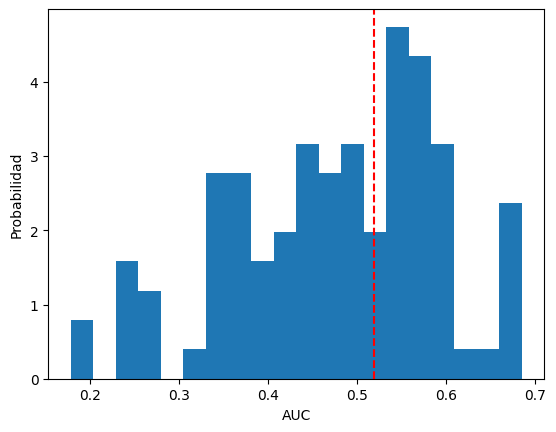

In [43]:
fig, ax = plt.subplots()

ax.hist(AUC_shuffled, bins=20, density=True) # armo el histograma de valores, normalizado para tener la probabilidad
ax.axvline(AUC, ls='--', color='r') # una linea vertical para indicar el AUC sin shufflear (modelo real)
ax.set_xlabel("AUC") # nombre de eje x
ax.set_ylabel("Probabilidad") # nombre de eje y

## Arboles de decision

In [55]:
# Modulos específicos para árboles de decisión
from sklearn.tree import DecisionTreeRegressor # Arboles de decisión para regresión
from sklearn.tree import plot_tree # Función para visualizar el árbol

from sklearn.ensemble import RandomForestRegressor # Random forests para decisión

# Módulos utiles para evaluar el modelo 
from sklearn.model_selection import train_test_split # Para separar en train y test
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

In [57]:
# Solo por esta vez para a fijar la semilla de numeros aleatorios
# para que se separe siempre igual cada vez que corramos esta notebook 
random_seed = 123475

In [58]:
# Construcción del árbol de decisión de profundidad 3 
dtr = DecisionTreeRegressor(max_depth = 5, random_state = random_seed)

# Observación: todos los algoritmos tienen una componente aleatoria: 
# solo por esta vez permitanme fijar la semilla de numeros aleatorios para que los resultados sean reproducibles.

In [ ]:
# Definamos la matriz X
X = train_set.drop(['cod', 'label'], axis=1).values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = train_set['label'] # Nuestra etiqueta sigue siende la misma de antes
X_test = test_set.drop(['cod', 'label'], axis=1).values
y_test = test_set['label']


In [60]:
# Entrenamiento del modelo con el método fit
dtr.fit(X, y)

DecisionTreeRegressor(max_depth=5, random_state=123475)

In [61]:
# Score del modelo en los datos de entrenamiento (siempre esperamos que aquí sea alto)
score_in_train = dtr.score(X, y)

print('Score en el set de entrenamiento: {}'.format(score_in_train))

Score en el set de entrenamiento: 1.0


In [ ]:
# Score del modelo en los datos de testeo 
# (acá puede fluctuar pero en general es bajo respecto a los datos de entrenamiento)
score_in_test = dtr.score(X_test, y_test)

print('Score en el set de testeo: {}'.format(score_in_test))